In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import australia
import models
import mscthesis
import pandas as pd
import geopandas as gpd
import validation
import numpy as np
import datetime
import genericvalidation
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr

In [78]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 22.0

In [3]:
sampler = models.Sampler(
    model=models.PreferentialReturn(
        p=0.2,
        gamma=0.8,
        region_sampling=models.RegionTransitionZipf(
            beta=0.05,
        ),
        jump_size_sampling=models.JumpSizeTrueProb(),
    ),
    daily_trips_sampling=models.NormalDistribution(3.14, 1.8),
    n_days=7*20,
    geotweets_path="",
)

In [3]:
geotweets = mscthesis.read_geotweets_raw("../../dbs/australia/geotweets.csv").set_index('userid')

# Only look at weekday trips
geotweets = geotweets[(geotweets['weekday'] < 6) & (0 < geotweets['weekday'])]

# Remove users who don't have home visit in geotweets
home_visits = geotweets.query("label == 'home'").groupby('userid').size()
geotweets = geotweets.loc[home_visits.index]

# Remove users with less than 20 tweets
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)

# Remove users with only one region
regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)

# Ensure the tweets are sorted chronologically
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

In [4]:
geotweets.shape

(601369, 12)

In [5]:
baseline = models.geotweets_to_visits(geotweets)

In [332]:
geotweetsx = geotweets.loc[geotweets.groupby('userid').size()[:10].index]

In [ ]:
print(datetime.datetime.now())
visits = sampler.sample(geotweets)
print(datetime.datetime.now())

In [6]:
visits = pd.read_csv("../../dbs/australia/visits.csv").set_index('userid')
visits

,day,timeslot,kind,latitude,longitude,region
userid,,,,,,
36303,0,0,region,-33.748644,151.045860,121
36303,0,1,region,-33.698014,151.029889,111
36303,1,0,region,-33.748644,151.045860,121
36303,1,1,region,-33.750319,151.046052,135
36303,2,0,region,-33.748644,151.045860,121
...,...,...,...,...,...,...
790766431428194304,138,4,region,-33.888820,151.240760,1
790766431428194304,139,0,region,-33.888820,151.240760,1
790766431428194304,139,1,region,-33.892130,151.250500,10


In [8]:
visits.to_csv('./../../dbs/australia/visits.csv')

In [7]:
zones = australia.validation_zones()
hts = australia.validation_travel_survey()

In [8]:
home_locations = pd.read_csv('../../dbs/australia/homelocations.csv')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(home_locations.longitude, home_locations.latitude),
).to_crs(zones.crs)

In [9]:
zone_to_user = gpd.sjoin(home_locations, zones)[['zone', 'userid']]

In [10]:
def prepare_travel_survey(hts):
    hts = hts[['WAVE', 'zone', 'WEIGHTED_TRIPS', 'WEIGHTED_TOTAL_DISTANCE']].groupby(['WAVE', 'zone']).sum()
    hts = hts.WEIGHTED_TOTAL_DISTANCE / hts.WEIGHTED_TRIPS 
    hts = hts.loc['2018/19']
    return hts


def visits_to_trips(visits):
    def trip_dist(t):
        return mscthesis.haversine_distance(
            t.latitude_origin, t.longitude_origin, 
            t.latitude_destination, t.longitude_destination,
        )
    print("converting to trips")
    trips = mscthesis.visit_gaps(visits)
    print("calculating distances")
    trip_dists = trips.apply(trip_dist, axis=1)
    return trip_dists

def summarize_trips_per_zone(trips, user_zone):
    trip_summaries = pd.DataFrame.from_dict(dict(
        num_trips = trips.groupby('userid').size(),
        total_distance = trips.groupby('userid').sum(),
    ))
    zone_trips = user_zone.merge(trip_summaries, on='userid')
    zone_trips = zone_trips.groupby('zone').sum()
    zone_avg_distance = zone_trips.total_distance / zone_trips.num_trips
    return zone_avg_distance
    

In [11]:
groundtruth_avg_distance = prepare_travel_survey(hts)

In [12]:
model_trips = visits_to_trips(visits)
model_avg_distance = summarize_trips_per_zone(model_trips, zone_to_user)
model_avg_distance = model_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


In [13]:
baseline_trips = visits_to_trips(baseline)
baseline_avg_distance = summarize_trips_per_zone(baseline_trips, zone_to_user)
baseline_avg_distance = baseline_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


In [14]:
zone_size = zone_to_user.groupby('zone').size()
baseline_avg_distanceX = baseline_avg_distance[zone_size < 5]
model_avg_distanceX = model_avg_distance[zone_size < 5]
groundtruth_avg_distanceX = groundtruth_avg_distance[zone_size < 5]

In [34]:
australia_shp = gpd.read_file('../../dbs/australia/Australia_boundary.shp').to_crs("EPSG:8058")

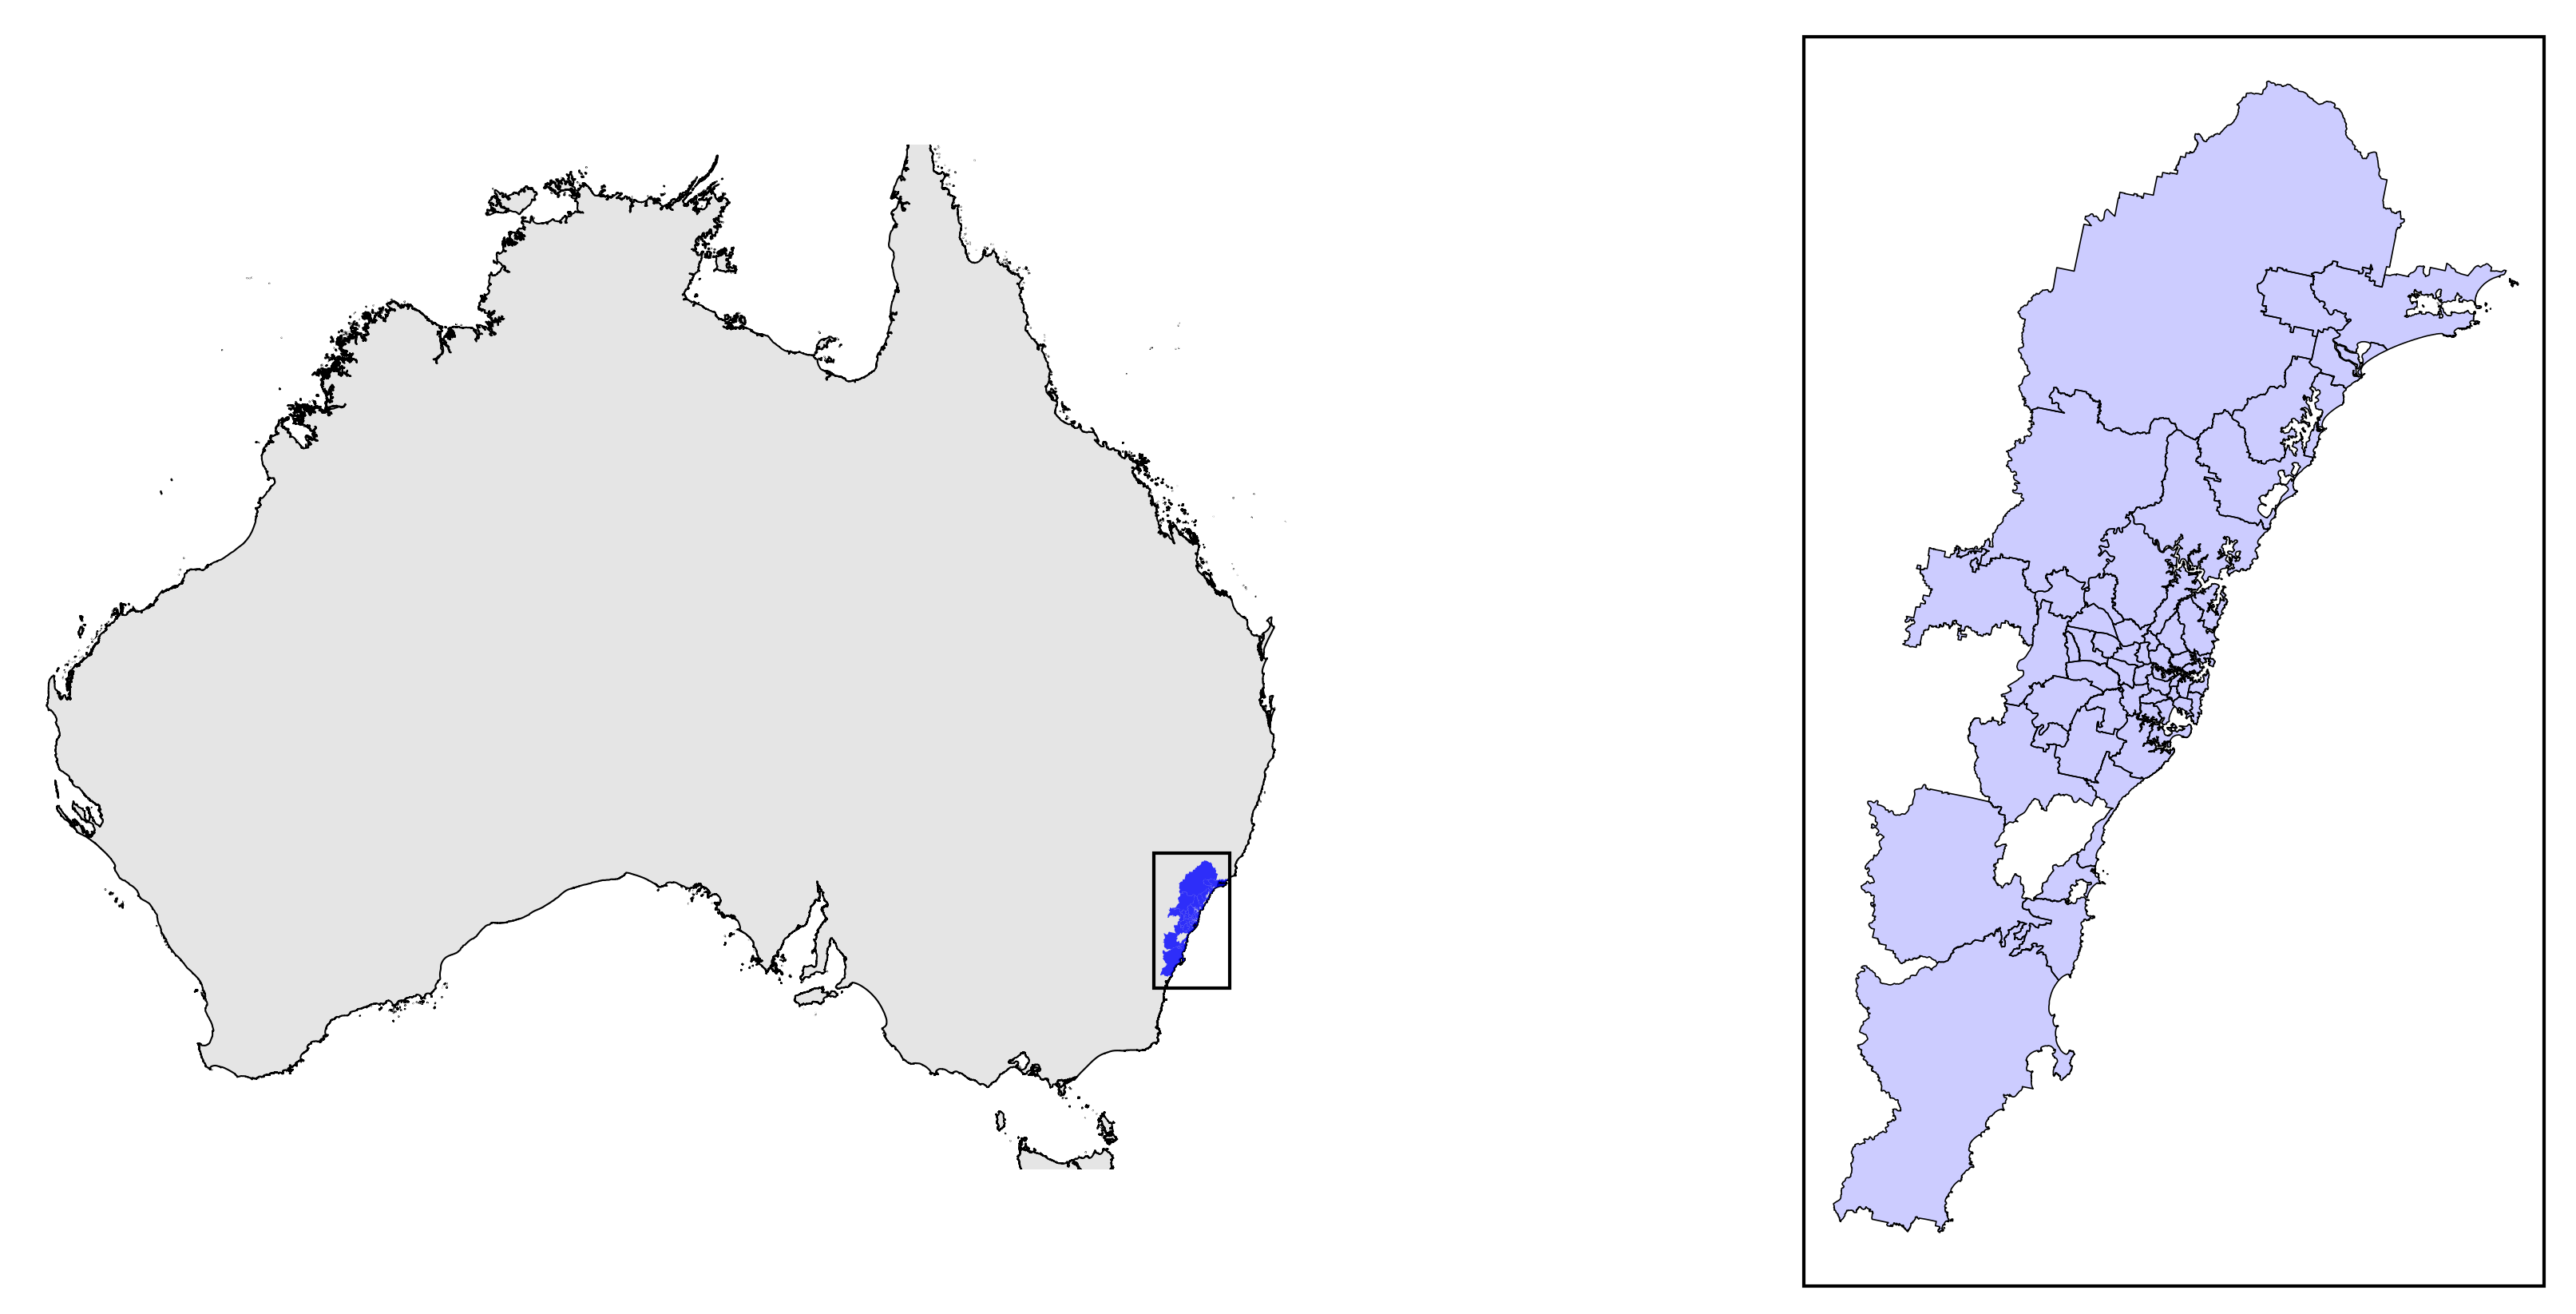

In [112]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
australia_shp.plot(ax = ax[0], edgecolor='black', facecolor=(0.5,0.5,0.5,0.2), linewidth=0.5)
ax[0].set_xlim(5800000, 10000000)
ax[0].set_ylim(3600000, 7000000)
zones.plot(ax = ax[0], edgecolor='none', facecolor=(0,0,1,0.8))
zones.plot(ax = ax[1], edgecolor='black', facecolor=(0,0,1,0.2), linewidth=0.4)
ax[0].set_axis_off()
ax[1].set_axis_off()
rect = mpl.patches.Rectangle((9550000,4200000),250000,450000, edgecolor='black', facecolor="none")
rect2 = mpl.patches.Rectangle((9560000,4220000),249000,420000, edgecolor='black', facecolor="none")
ax[0].add_patch(rect)
ax[1].add_patch(rect2)
#home_locations.plot(ax=ax[1], c='r', markersize=1)

In [60]:
model_avg_distance[model_avg_distance > 60]

zone
11904    66.44731
dtype: float64

Text(0.05, 0.9, 'B')

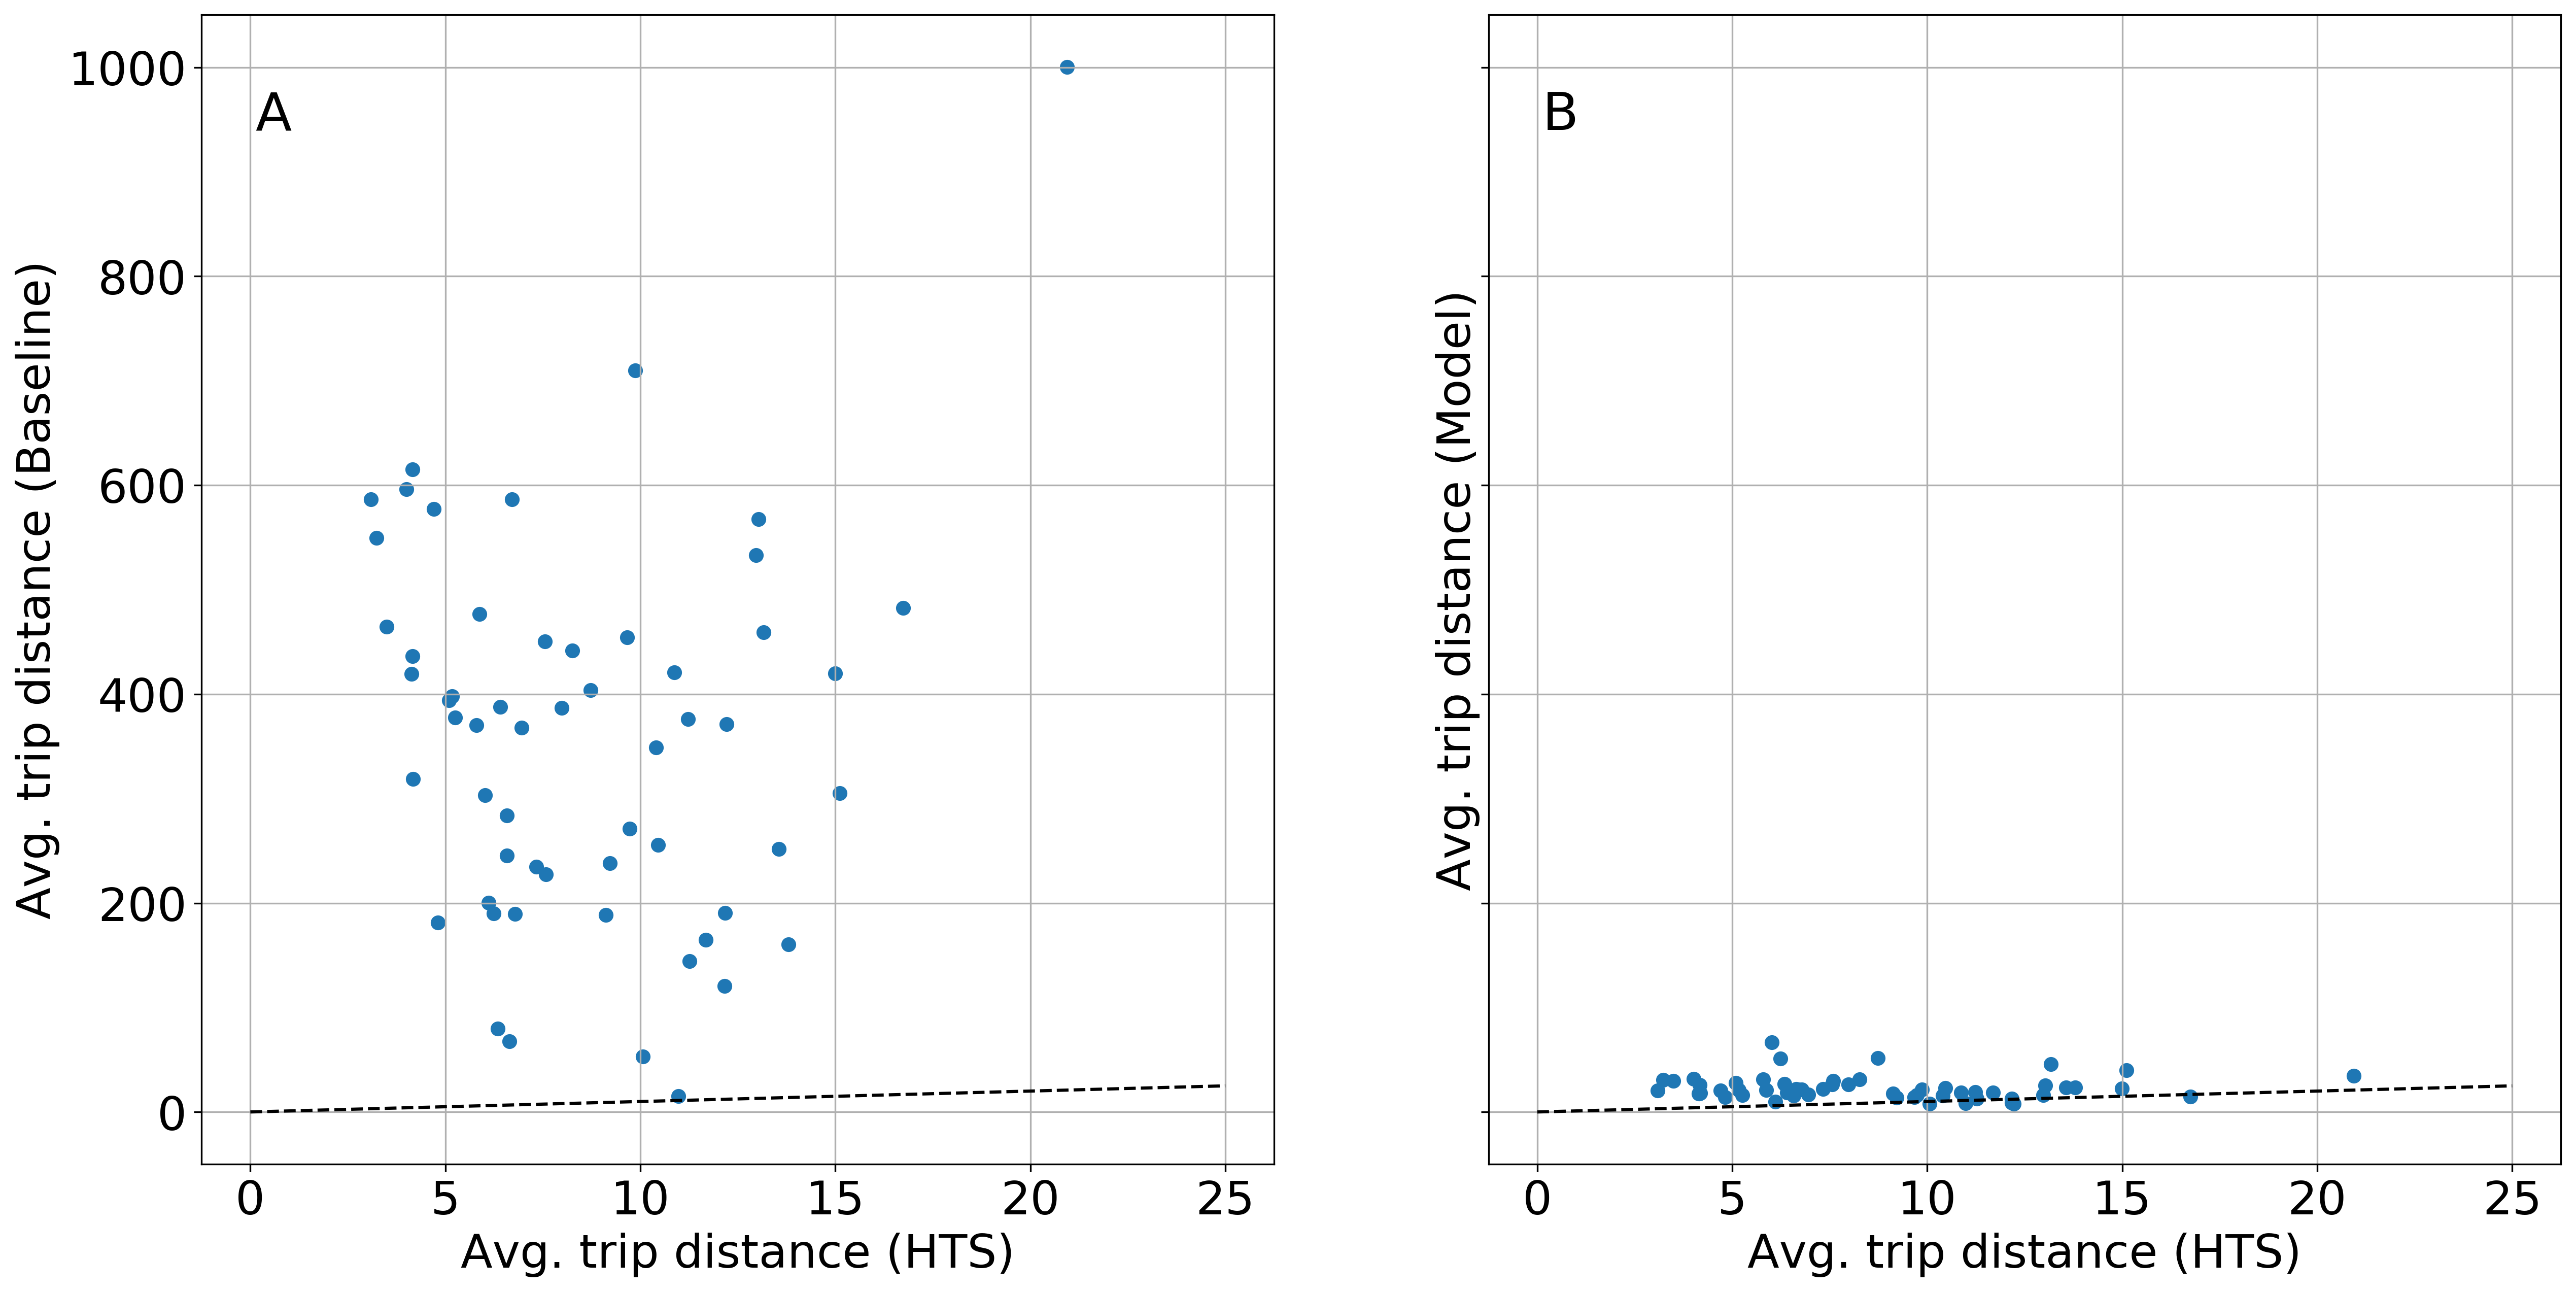

In [85]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)

axes[0].scatter(x=groundtruth_avg_distance, y=baseline_avg_distance)
axes[0].plot([0, 25], [0,25], '--', c='black')
axes[0].grid(True)
axes[1].scatter(x=groundtruth_avg_distance, y=model_avg_distance)
axes[1].plot([0, 25], [0,25], '--', c='black')
axes[1].grid(True)
axes[0].set_xlabel('Avg. trip distance (HTS)')
axes[0].set_ylabel('Avg. trip distance (Baseline)')
axes[1].set_xlabel('Avg. trip distance (HTS)')
axes[1].set_ylabel('Avg. trip distance (Model)')
axes[0].text(.05, .9, "A", transform=axes[0].transAxes, fontsize='25')
axes[1].text(.05, .9, "B", transform=axes[1].transAxes, fontsize='25')

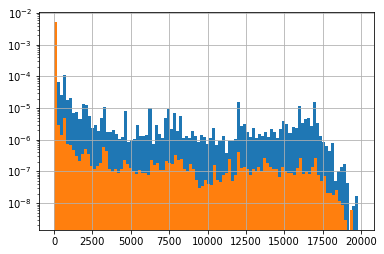

In [22]:
ax = baseline_trips.hist(log=True, bins=100, density=True)
model_trips.hist(ax=ax,log=True, bins=100, density=True)

In [90]:
import saopaulo
brazil_shp = gpd.read_file('../../dbs/saopaulo/Brazil_Boundary.shp').to_crs("EPSG:22523")

In [89]:
zones_sao = saopaulo.zones()
zones_sao.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W and south of 15°S
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

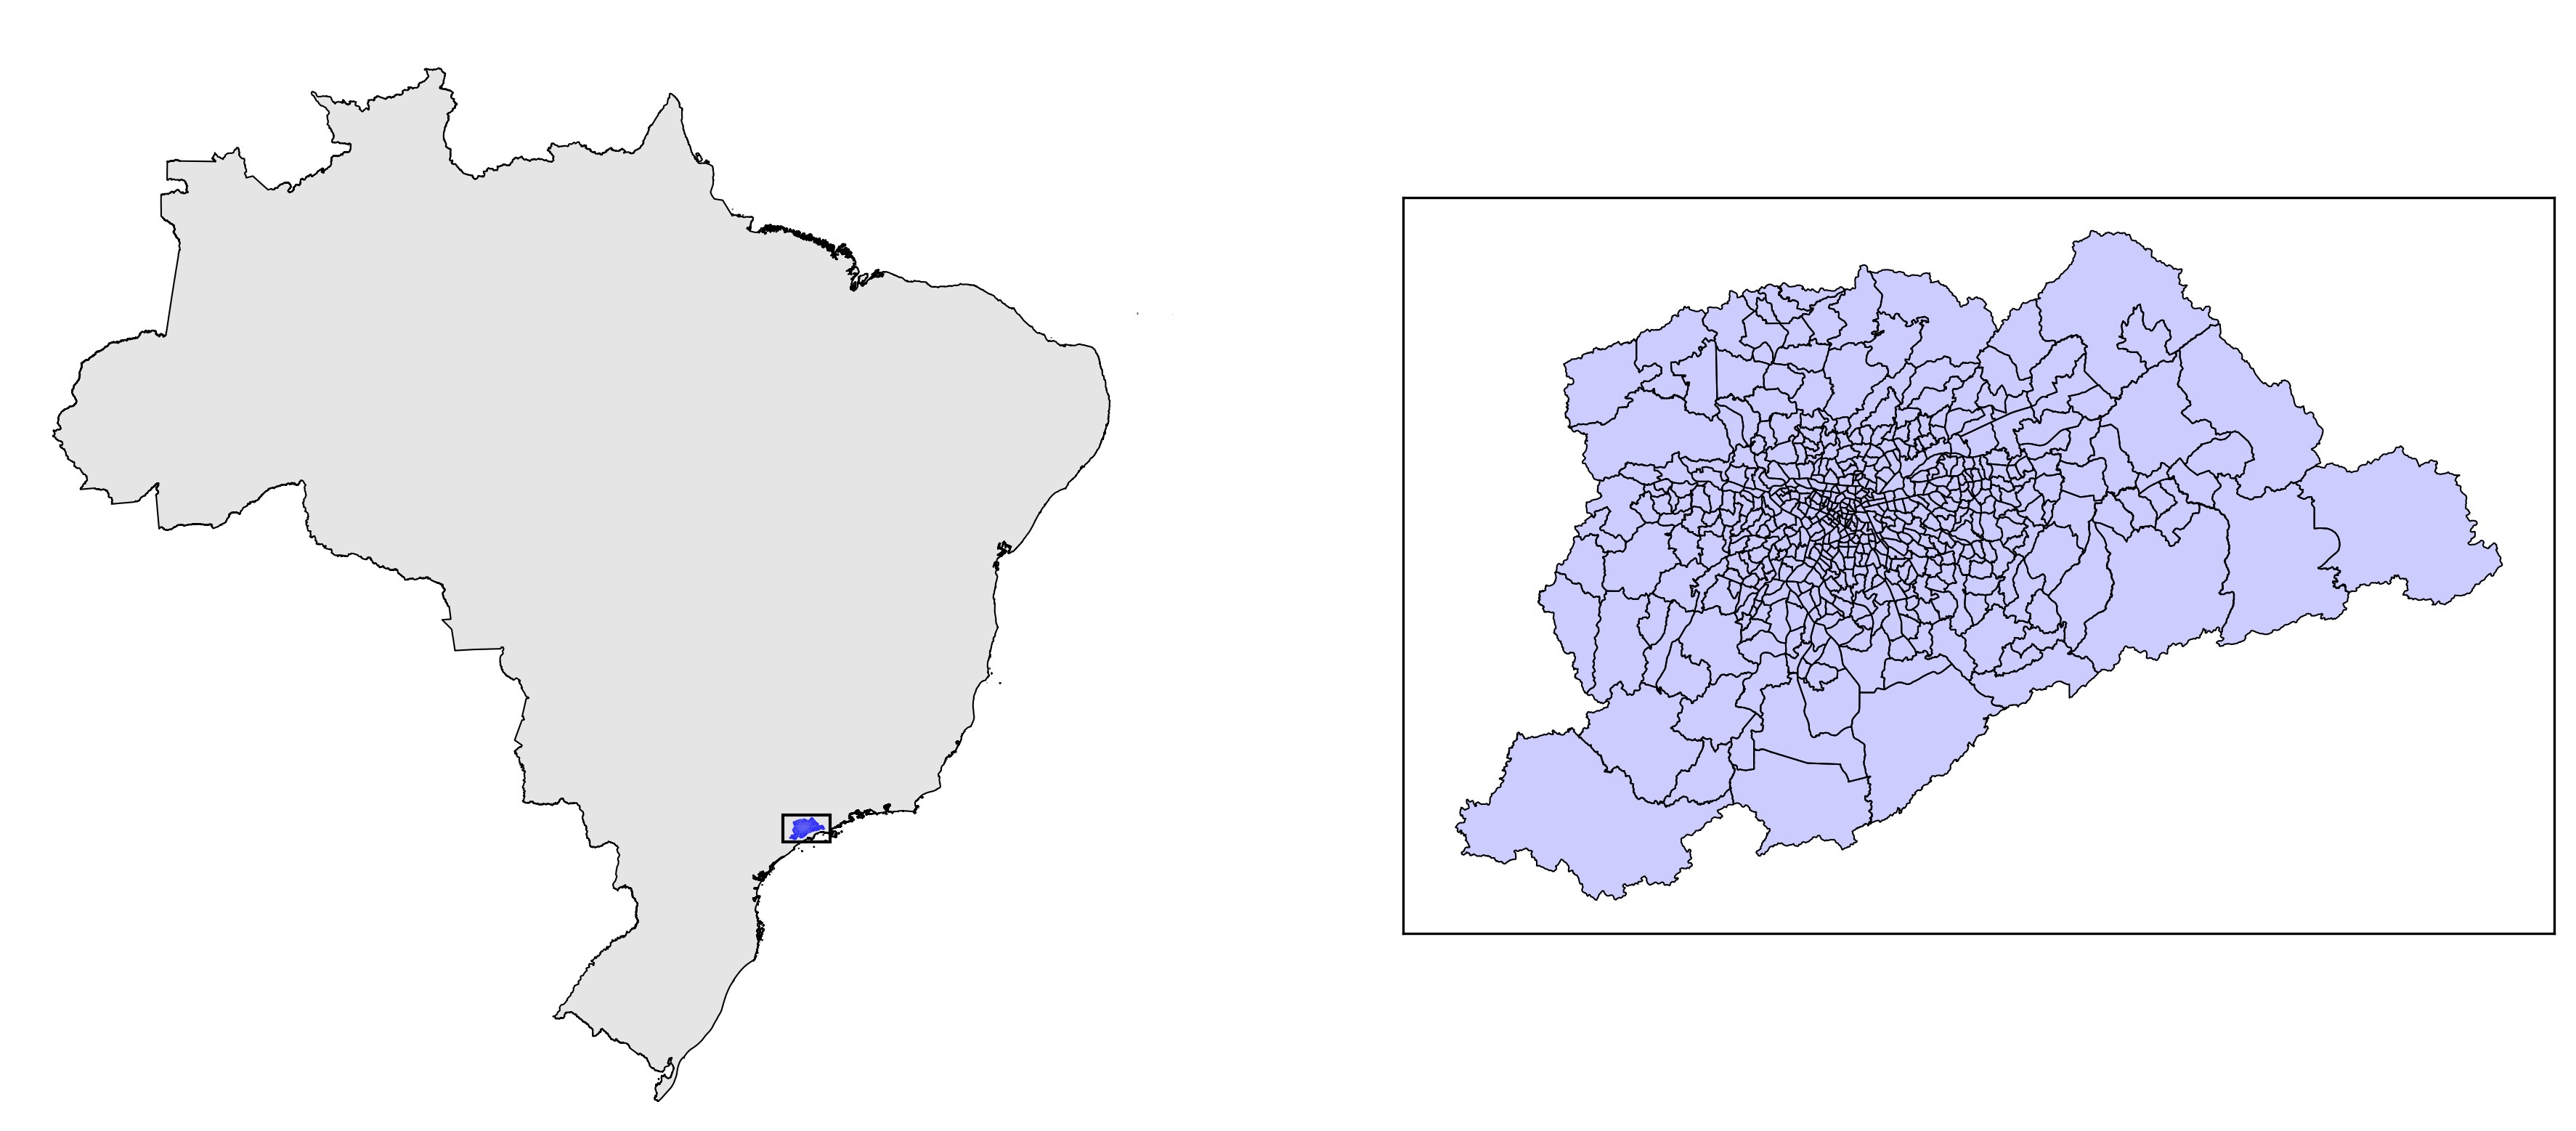

In [110]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))
brazil_shp.plot(ax=ax[0], edgecolor='black', facecolor=(0.5,0.5,0.5,0.2), linewidth=0.5)
ax[0].set_xlim(-2970000, 1900000)
ax[0].set_ylim(6200000, 10800000)
zones_sao.plot(ax=ax[0], edgecolor='none', facecolor=(0,0,1,0.8), linewidth=0.5)
zones_sao.plot(ax=ax[1], edgecolor='black', facecolor=(0,0,1,0.2), linewidth=0.5)
ax[0].set_axis_off()
rect = mpl.patches.Rectangle((250000, 7330000),200000,115000, edgecolor='black', facecolor="none")
ax[0].add_patch(rect)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)